In [1]:
from timeit import default_timer as timer
import numpy as np
import pandas as pd
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras_helper import NNWeightHelper
from snes import SNES
import os
import cv2
import matplotlib.pyplot as plt
from dataSet import dataSet

Using TensorFlow backend.


In [2]:
#randomforest classifier
def train_classifier(model, X, y):
    X_features = model.predict(X)
    clf = RandomForestClassifier(n_estimators=10)
    clf.fit(X_features, y)
    y_pred = clf.predict(X_features)
    return clf, y_pred
#prediction 
def predict_classifier(model, clf, X):
    X_features = model.predict(X)
    return clf.predict(X_features)
# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 31

# use just a small sample of the train set to test
SAMPLE_SIZE = 300
# how many different sets of weights ask() should return for evaluation
POPULATION_SIZE = 20
# how many times we will loop over ask()/tell()
GENERATIONS = 60

In [3]:
#Loading the data from path-
# This part adopted from LYU CHAOFAN_Github(permission was obtained)https://github.com/C-002/CE888_Assignment/blob/master/LoadImages.ipynb
Amazon_path = './Original_images/amazon/images'
dslr_path   = './Original_images/dslr/images'
webcam_path = './Original_images/webcam/images'
paths = [Amazon_path, dslr_path, webcam_path]
files = os.listdir(Amazon_path)
labels = {}
count  = 0
for key in files:
    a = {key : count}
    labels.update(a)
    count += 1
#print (labels)

images_path = []
dslr   = dataSet()
webcam = dataSet()
#loading DSLR data
for dirname in files:
    images_name = os.listdir(dslr_path + '/' + dirname)
    for name in images_name:
        Image_Path = dslr_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        dslr.upData(image_data, labels[dirname], labels)
dslr.sHape()
#loading webcam data
for dirname in files:
    images_name = os.listdir(webcam_path + '/' + dirname)
    for name in images_name:
        Image_Path = webcam_path + '/' + dirname + '/' + name
        images_path.append(Image_Path)
        image_data = cv2.imread(Image_Path)
        image_data = cv2.resize(image_data, (img_rows, img_cols), interpolation=cv2.INTER_CUBIC)
        image_data = image_data.reshape(img_rows, img_cols, 3)
        webcam.upData(image_data, labels[dirname], labels)
webcam.sHape()

#label classifier data
x_train = dslr.data
y_train = dslr.label
x_test  = webcam.data
y_test  = webcam.label
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
input_shape = (img_rows, img_cols, 3)
#data normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
#domain classifier data
x_domain=np.concatenate((x_train,x_test), axis =0)
y_domain = np.concatenate((np.zeros(y_train.shape[0]), np.ones(y_test.shape[0])),axis=0)
print("For label classifier")
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print("For domain classifier")
print('x_domain shape:', x_domain.shape)
print(y_domain.shape[0], 'domain samples')

For label classifier
x_train shape: (498, 28, 28, 3)
x_test shape: (795, 28, 28, 3)
498 train samples
795 test samples
For domain classifier
x_domain shape: (1293, 28, 28, 3)
1293 domain samples


In [4]:
#the neural network model
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5),activation='relu',input_shape=(28,28,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
nnw = NNWeightHelper(model)
weights = nnw.get_weights()

In [5]:
print("Total number of weights to evolve is:", weights.shape)
all_examples_indices = list(range(x_train.shape[0]))
clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)
print('x_test shape:',y_test.shape)
print('x_pred shape:',y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)
print('Non-trained NN Test accuracy:', test_accuracy)

Total number of weights to evolve is: (156196,)


x_test shape: (795,)
x_pred shape: (795,)
Non-trained NN Test accuracy: 0.1069182389937107


In [6]:
#evolutionary process with SNES
snes = SNES(weights, 1, POPULATION_SIZE)
log = []
for i in range(0, GENERATIONS):
    start = timer()
    asked = snes.ask()

    # to be provided back to snes
    told = []
    # use a small number of training samples for speed purposes
    subsample_indices = np.random.choice(all_examples_indices, size=SAMPLE_SIZE, replace=False)
    # evaluate on another subset
    subsample_indices_valid = np.random.choice(all_examples_indices, size=SAMPLE_SIZE + 1, replace=False)

    # iterate over the population
    for asked_j in asked:
        # set nn weights
        nnw.set_weights(asked_j)
        # train the classifer and get back the predictions on the training data
        clf, _ = train_classifier(model, x_train[subsample_indices], y_train[subsample_indices])
        clf2, _ = train_classifier(model, x_domain[subsample_indices], y_domain[subsample_indices])

        # calculate the predictions on a different set
        y_pred = predict_classifier(model, clf, x_train[subsample_indices_valid])
        score = accuracy_score(y_train[subsample_indices_valid], y_pred)

        y_pred2 = predict_classifier(model, clf, x_domain[subsample_indices_valid])
        score2 = accuracy_score(y_domain[subsample_indices_valid], y_pred)
                    
        # append to array of values that are to be returned
        total=score+score2
        told.append(total)

    t = snes.tell(asked, told)
    log.append(t)
    end = timer()
    print("It took", end - start, "seconds to complete generation", i + 1)
nnw.set_weights(snes.center)

clf, _ = train_classifier(model, x_train, y_train)
y_pred = predict_classifier(model, clf, x_test)
print(y_test.shape, y_pred.shape)
test_accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy on target:', test_accuracy)

Step 1.0 : 0.7774086378737541 best: 0.7774086378737541 20
It took 12.053712015667474 seconds to complete generation 1


Step 2.0 : 0.7674418604651163 best: 0.7774086378737541 20
It took 11.564772020836836 seconds to complete generation 2


Step 3.0 : 0.7641196013289037 best: 0.7774086378737541 20
It took 11.725097401601374 seconds to complete generation 3


Step 4.0 : 0.73421926910299 best: 0.7774086378737541 20
It took 12.568020680275566 seconds to complete generation 4


Step 5.0 : 0.7940199335548173 best: 0.7940199335548173 20
It took 12.790620320112673 seconds to complete generation 5


Step 6.0 : 0.7574750830564784 best: 0.7940199335548173 20
It took 14.449390836685836 seconds to complete generation 6


Step 7.0 : 0.7707641196013288 best: 0.7940199335548173 20
It took 13.822400622862489 seconds to complete generation 7


Step 8.0 : 0.7740863787375415 best: 0.7940199335548173 20
It took 14.127176571851521 seconds to complete generation 8


Step 9.0 : 0.760797342192691 best: 0.7940199335548173 20
It took 13.13512667232969 seconds to complete generation 9


Step 10.0 : 0.7740863787375416 best: 0.7940199335548173 20
It took 12.721383640480283 seconds to complete generation 10


Step 11.0 : 0.7308970099667774 best: 0.7940199335548173 20
It took 12.48903343830736 seconds to complete generation 11


Step 12.0 : 0.770764119601329 best: 0.7940199335548173 20
It took 12.415669730554868 seconds to complete generation 12


Step 13.0 : 0.760797342192691 best: 0.7940199335548173 20
It took 12.418430015596243 seconds to complete generation 13


Step 14.0 : 0.7707641196013288 best: 0.7940199335548173 20
It took 12.585913166679518 seconds to complete generation 14


Step 15.0 : 0.7906976744186047 best: 0.7940199335548173 20
It took 12.353738215102652 seconds to complete generation 15


Step 16.0 : 0.7740863787375415 best: 0.7940199335548173 20
It took 13.213246124123287 seconds to complete generation 16


Step 17.0 : 0.7375415282392026 best: 0.7940199335548173 20
It took 13.093629305848964 seconds to complete generation 17


Step 18.0 : 0.7541528239202658 best: 0.7940199335548173 20
It took 13.442183700002005 seconds to complete generation 18


Step 19.0 : 0.7674418604651162 best: 0.7940199335548173 20
It took 12.986021913729473 seconds to complete generation 19


Step 20.0 : 0.7807308970099667 best: 0.7940199335548173 20
It took 13.06910127474535 seconds to complete generation 20


Step 21.0 : 0.7774086378737541 best: 0.7940199335548173 20
It took 13.379208791162341 seconds to complete generation 21


Step 22.0 : 0.7342192691029901 best: 0.7940199335548173 20
It took 13.602234039589689 seconds to complete generation 22


Step 23.0 : 0.7807308970099668 best: 0.7940199335548173 20
It took 12.995947374044363 seconds to complete generation 23


Step 24.0 : 0.8039867109634551 best: 0.8039867109634551 20
It took 13.218829460013069 seconds to complete generation 24


Step 25.0 : 0.8073089700996677 best: 0.8073089700996677 20
It took 12.636999244342007 seconds to complete generation 25


Step 26.0 : 0.7641196013289037 best: 0.8073089700996677 20
It took 12.79539545808285 seconds to complete generation 26


Step 27.0 : 0.770764119601329 best: 0.8073089700996677 20
It took 12.675184832960099 seconds to complete generation 27


Step 28.0 : 0.7574750830564784 best: 0.8073089700996677 20
It took 12.962628603788744 seconds to complete generation 28


Step 29.0 : 0.7408637873754153 best: 0.8073089700996677 20
It took 12.617455100409416 seconds to complete generation 29


Step 30.0 : 0.760797342192691 best: 0.8073089700996677 20
It took 12.48781691002523 seconds to complete generation 30


Step 31.0 : 0.7840531561461793 best: 0.8073089700996677 20
It took 13.623333224022076 seconds to complete generation 31


Step 32.0 : 0.7508305647840532 best: 0.8073089700996677 20
It took 13.241539751031326 seconds to complete generation 32


Step 33.0 : 0.760797342192691 best: 0.8073089700996677 20
It took 13.059537951979905 seconds to complete generation 33


Step 34.0 : 0.7740863787375415 best: 0.8073089700996677 20


It took 12.86054425007029 seconds to complete generation 34


Step 35.0 : 0.7475083056478405 best: 0.8073089700996677 20
It took 13.609682013611746 seconds to complete generation 35


Step 36.0 : 0.760797342192691 best: 0.8073089700996677 20
It took 13.554131100845211 seconds to complete generation 36


Step 37.0 : 0.7840531561461794 best: 0.8073089700996677 20
It took 13.753958389090883 seconds to complete generation 37


Step 38.0 : 0.7508305647840532 best: 0.8073089700996677 20
It took 13.241399409507721 seconds to complete generation 38


Step 39.0 : 0.7740863787375416 best: 0.8073089700996677 20
It took 13.504979126843011 seconds to complete generation 39


Step 40.0 : 0.7774086378737541 best: 0.8073089700996677 20
It took 13.584721321579934 seconds to complete generation 40


Step 41.0 : 0.7475083056478405 best: 0.8073089700996677 20
It took 14.2437203339 seconds to complete generation 41


Step 42.0 : 0.7774086378737541 best: 0.8073089700996677 20
It took 13.82446872094215 seconds to complete generation 42


Step 43.0 : 0.7774086378737541 best: 0.8073089700996677 20
It took 13.063363140039314 seconds to complete generation 43


Step 44.0 : 0.7408637873754153 best: 0.8073089700996677 20
It took 12.88362725714478 seconds to complete generation 44


Step 45.0 : 0.7541528239202658 best: 0.8073089700996677 20
It took 12.626241608158693 seconds to complete generation 45


Step 46.0 : 0.7441860465116279 best: 0.8073089700996677 20
It took 12.684974183154168 seconds to complete generation 46


Step 47.0 : 0.760797342192691 best: 0.8073089700996677 20
It took 12.899827182460626 seconds to complete generation 47


Step 48.0 : 0.7475083056478405 best: 0.8073089700996677 20
It took 13.90387346131206 seconds to complete generation 48


Step 49.0 : 0.7807308970099668 best: 0.8073089700996677 20
It took 14.459550082001101 seconds to complete generation 49


Step 50.0 : 0.7408637873754153 best: 0.8073089700996677 20
It took 15.154244149821238 seconds to complete generation 50


Step 51.0 : 0.770764119601329 best: 0.8073089700996677 20
It took 14.095855376296868 seconds to complete generation 51


Step 52.0 : 0.7209302325581395 best: 0.8073089700996677 20
It took 13.409870240509463 seconds to complete generation 52


Step 53.0 : 0.73421926910299 best: 0.8073089700996677 20
It took 13.060414557576905 seconds to complete generation 53


Step 54.0 : 0.7674418604651163 best: 0.8073089700996677 20
It took 13.253274136009281 seconds to complete generation 54


Step 55.0 : 0.770764119601329 best: 0.8073089700996677 20
It took 12.598195870926702 seconds to complete generation 55


Step 56.0 : 0.7973421926910299 best: 0.8073089700996677 20
It took 13.817124063669894 seconds to complete generation 56


Step 57.0 : 0.7475083056478405 best: 0.8073089700996677 20
It took 12.789819174530976 seconds to complete generation 57


Step 58.0 : 0.7774086378737541 best: 0.8073089700996677 20
It took 13.17298996910722 seconds to complete generation 58


Step 59.0 : 0.7541528239202657 best: 0.8073089700996677 20
It took 12.722711948317738 seconds to complete generation 59


Step 60.0 : 0.7441860465116279 best: 0.8073089700996677 20
It took 13.595620709754371 seconds to complete generation 60


(795,) (795,)
Test accuracy on target: 0.1509433962264151


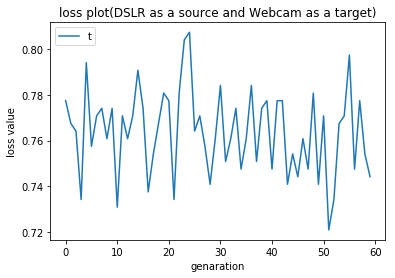

In [7]:
#Plot the loss for each generation
plt.plot(log)
plt.title('loss plot(DSLR as a source and Webcam as a target)')
plt.xlabel('genaration')
plt.ylabel('loss value')
plt.legend('test', loc='upper left')
plt.savefig('Plot_Dslr_webcam.png')
plt.show()